<a href="https://colab.research.google.com/github/livjab/DS-Unit-2-Sprint-3-Classification-Validation/blob/master/DS_Unit_2_Sprint_Challenge_3_Classification_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 _Lambda School Data Science Unit 2_
 
 # Classification & Validation Sprint Challenge

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

#### For this Sprint Challenge, you'll predict whether a person's income exceeds $50k/yr, based on census data.

You can read more about the Adult Census Income dataset at the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/adult

#### Run this cell to load the data:

In [0]:
import pandas as pd

columns = ['age', 
           'workclass', 
           'fnlwgt', 
           'education', 
           'education-num', 
           'marital-status', 
           'occupation', 
           'relationship', 
           'race', 
           'sex', 
           'capital-gain', 
           'capital-loss', 
           'hours-per-week', 
           'native-country', 
           'income']

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                 header=None, names=columns)

df['income'] = df['income'].str.strip()

In [7]:
df.shape

(32561, 15)

In [49]:
df.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


## Part 1 — Begin with baselines

Split the data into an **X matrix** (all the features) and **y vector** (the target).

(You _don't_ need to split the data into train and test sets here. You'll be asked to do that at the _end_ of Part 1.)

In [0]:
X = df.drop(columns="income")
y = df["income"] == '>50K'

In [104]:
X.shape

(32561, 14)

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You can answer this question either with a scikit-learn function or with a pandas function.)

In [0]:
# predicting majority class for all predictions

majority_class = y.mode()[0]
y_pred = [majority_class] * len(y)

In [11]:
# accuracy score using sklearn

from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

0.7591904425539756

In [12]:
# using pandas to compare scores

y.value_counts(normalize=True)

False    0.75919
True     0.24081
Name: income, dtype: float64

What **ROC AUC score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of ROC AUC.)

In [13]:
# My guess would be 0.5 but lets check with sklearn

from sklearn.metrics import roc_auc_score
roc_auc_score(y, y_pred)

0.5

In this Sprint Challenge, you will use **"Cross-Validation with Independent Test Set"** for your model validaton method.

First, **split the data into `X_train, X_test, y_train, y_test`**. You can include 80% of the data in the train set, and hold out 20% for the test set.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

BONUS -- Do feature engineering, to try improving your cross-validation score.

(spoiler: I did not complete this step )

In [50]:
# let's check out the cardinality of our categorical features

X_train.select_dtypes(exclude="number").nunique()

workclass          9
education         16
marital-status     7
occupation        15
relationship       6
race               5
sex                2
native-country    42
dtype: int64

In [61]:
# relativel high cardinality for native-country
# going to combine categories to make the data less sparse once its encoded

X["native-country"].value_counts().head(10)

 United-States    29170
 Mexico             643
 ?                  583
 Philippines        198
 Germany            137
 Canada             121
 Puerto-Rico        114
 El-Salvador        106
 India              100
 Cuba                95
Name: native-country, dtype: int64

In [0]:
# combine into two total categories -- United States and other

cond = (df["native-country"] == "United-States")

df["native-country"] = df["native-country"].where(cond, "Outside United States")

In [0]:
# ran out of time to get the above plan working

## Part 2 — Modeling with Logistic Regression!

- You may do exploratory data analysis and visualization, but it is not required.
- You may **use all the features, or select any features** of your choice, as long as you select at least one numeric feature and one categorical feature.
- **Scale your numeric features**, using any scikit-learn [Scaler](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) of your choice.
- **Encode your categorical features**. You may use any encoding (One-Hot, Ordinal, etc) and any library (category_encoders, scikit-learn, pandas, etc) of your choice.
- You may choose to use a pipeline, but it is not required.
- Use a **Logistic Regression** model.
- Use scikit-learn's [**cross_val_score**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function. For [scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules), use **accuracy**.
- **Print your model's cross-validation accuracy score.**

In [15]:
!pip install category_encoders

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [82]:
# first attempt -- using all featuers, standard scaler, 3-fold cross validation

pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True), 
                        SimpleImputer(), 
                        StandardScaler(), 
                        LogisticRegression(solver='lbfgs', max_iter=1000))

scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=3)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.8512035  0.84878498 0.85418106]


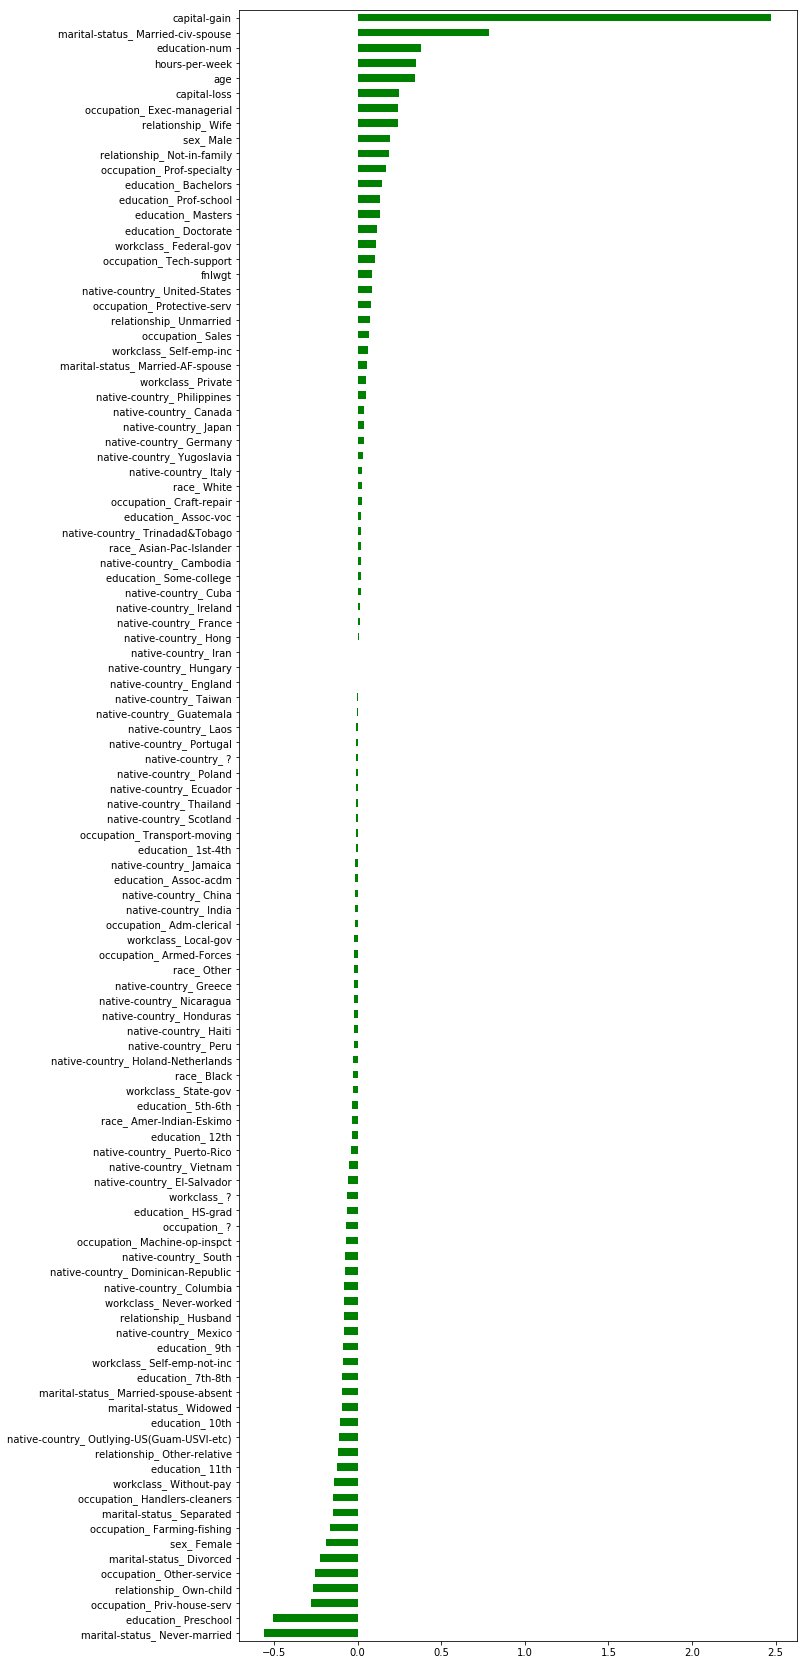

In [83]:
# visualizing coefficients to determine which to use

pipeline.fit(X_train, y_train)

plt.figure(figsize=(10,30))

coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = pipeline.named_steps['onehotencoder'].transform(X_train).columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='green');

In [0]:
# second attempt, limiting features and adding more cross-validation splits

features = df[["capital-gain", "education-num", "hours-per-week", "age", "sex"]]

In [109]:
# re calibrate test/train
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2)

pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True), 
                        SimpleImputer(), 
                        StandardScaler(), 
                        LogisticRegression(solver='lbfgs', max_iter=1000))

scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.82310054 0.82034549 0.81420345 0.81113244 0.81919386 0.82955854
 0.81573896 0.82104455 0.83371736 0.8202765 ]


In [0]:
# the features I chose did not improve my logistic resgression model

## Part 3 — Modeling with Tree Ensembles!

Part 3 is the same as Part 2, except this time, use a **Random Forest** or **Gradient Boosting** classifier. You may use scikit-learn, xgboost, or any other library. Then, print your model's cross-validation accuracy score.

In [47]:
# random forest using all features, minmax scaler, 3-fold cross validation

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True), 
                        SimpleImputer(), 
                        MinMaxScaler(), 
                        RandomForestClassifier(max_depth=None, n_estimators=100, n_jobs=-1))

scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=3)
print("Cross_Validation Accuracy Scores", scores)

Cross_Validation Accuracy Scores [0.85465853 0.85247034 0.85418106]


In [110]:
#going to try the same limiting features as above with the decision tree

features = df[["capital-gain", "education-num", "hours-per-week", "age", "sex"]]

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2)

pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True), 
                        SimpleImputer(), 
                        MinMaxScaler(), 
                        RandomForestClassifier(max_depth=None, n_estimators=100, n_jobs=-1))

scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.81957774 0.8134357  0.81228407 0.82072937 0.80998081 0.81036468
 0.81458733 0.81381958 0.81298003 0.81528418]


In [0]:
# the features I chose also did not improve my random forest model

In [113]:
# let's to try xgboost model

from xgboost import XGBClassifier


pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True), 
                        SimpleImputer(), 
                        MinMaxScaler(), 
                        XGBClassifier(max_depth=3, n_estimators=100, n_jobs=-1))

scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=3)
print("Cross_Validation Accuracy Scores", scores)

Cross_Validation Accuracy Scores [0.84049292 0.8380744  0.83149044]


## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

In [0]:
  true_negative  = 85
  false_positive = 58
  false_negative = 8
  true_positive  = 36

  actual_negative = 85 + 58
  actual_positive = 8 + 36

  predicted_negative = 85 + 8
  predicted_positive = 58 + 36

Calculate accuracy

In [35]:
accuracy = (true_positive + true_negative) / (predicted_negative + predicted_positive)
print("Accuracy:", accuracy)

Accuracy: 0.6470588235294118


Calculate precision

In [36]:
precision = true_positive / predicted_positive
print("Precision:", precision)

Precision: 0.3829787234042553


Calculate recall

In [37]:
recall = true_positive / actual_positive
print("Recall:", recall)

Recall: 0.8181818181818182


BONUS -- Calculate F1 score and False Positive Rate

In [38]:
f1 = 2 * precision * recall / (precision + recall)
print("F1:", f1)

F1: 0.5217391304347826


In [39]:
false_positive_rate = false_positive / actual_negative
print("False Positive Rate:", false_positive_rate)

False Positive Rate: 0.40559440559440557


## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Experiment with feature selection, preprocessing, categorical encoding, and hyperparameter optimization, to try improving your cross-validation score.

### Part 3
Which model had the best cross-validation score? Refit this model on the train set and do a final evaluation on the held out test set — what is the test score? 

### Part 4
Calculate F1 score and False Positive Rate. 